<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [5]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [6]:
tf.reset_default_graph()

batch_size  = 256
hidden_size = 8

def inference(in_net):
    with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
    return net

def generator(in_net):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
        net = tf.layers.dense(net, 784, name='dense_5', activation=None)
    return net

lr    = tf.placeholder_with_default(0.001,shape=[])

x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

mu, sigma        = tf.split(inference(x), 2, axis=-1)
sigma            = tf.nn.softplus(sigma) + 0.0001
approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

z = approx_posterior.sample()

sample_size = tf.placeholder_with_default(100,shape=[])

z_samples = approx_posterior.sample(sample_size)

x_samples = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

x_sims = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

kl_divergence = tfd.kl_divergence(approx_posterior, prior)

elbo = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)


with tf.variable_scope("posterior2"):
    mu_t = tf.Variable(initial_value=np.zeros((batch_size,hidden_size)), dtype=tf.float32)
    sigma_t = tf.Variable(initial_value=np.ones((batch_size,hidden_size *(hidden_size +1) // 2)), dtype=tf.float32)
sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_t), transform=tf.nn.softplus)

approx_posterior2 = tfd.MultivariateNormalTriL(loc=mu_t,scale_tril=sigma_t2, name='posterior2')

z2                = approx_posterior2.sample()

kl_divergence2    = tfd.kl_divergence(approx_posterior2, prior) 

data_likelihood2  = tfd.Independent(tfd.Bernoulli(logits=generator(z2)))
    
elbo2             = -tf.reduce_mean(data_likelihood2.log_prob(x) - kl_divergence2,axis=0)

z2_samples        = approx_posterior2.sample(sample_size)

x2_samples        = tfd.Independent(tfd.Bernoulli(logits=generator(z2_samples))).sample(sample_size)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)

opt_op2 = optimizer.minimize(elbo2,var_list=[mu_t,sigma_t])

Instructions for updating:
Use tf.cast instead.


In [0]:
# with tf.Session() as sess:
#   # `sess.graph` provides access to the graph used in a <a href="./../api_docs/python/tf/Session"><code>tf.Session</code></a>.
#   writer = tf.summary.FileWriter("/tmp/log/...", sess.graph)

#   sess.run(tf.global_variables_initializer())
  
#   nepochs=10
#   for ep in range(nepochs):
#     gen = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
#     count = 0
#     print('new epoch')
    
#     for i in range(50000 // batch_size):
#         # Train the inference model
#         imgs = next(gen)
        
#         if len(imgs) < batch_size:
#             imgs = next(gen)
            
#         imgs = imgs.reshape([-1,784])

#         # Train the generative model
#         _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:0.0001})
        
#         losses_data.append(l)
        
#         count += 1
#         if count % 10 ==0:
#             print(ep, l)

#   writer.close()

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:
losses_data = []

In [12]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [15]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-5
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = imgs.reshape([-1,784])
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 126.67143 108.481995 0.0
0 120.859024 112.740036 0.0
0 122.81372 113.50632 0.0
0 126.51499 107.773254 0.0
0 125.03028 106.17628 0.0
0 123.19236 107.31735 0.0
0 121.60699 110.47008 0.0
0 124.410355 113.31059 0.0
0 123.279205 116.12674 0.0
0 123.84527 109.86868 0.0
0 124.867424 108.2926 0.0
0 119.179985 112.33771 0.0
0 118.85275 108.45008 0.0
0 122.45232 110.850975 0.0
0 122.6942 112.91821 0.0
0 122.23363 104.879456 0.0
0 124.26631 107.94133 0.0
0 120.391235 107.41424 0.0
0 119.95776 103.46455 0.0
new epoch
1 120.52576 107.360855 0.0
1 122.58038 112.33916 0.0
1 119.724625 112.64238 0.0
1 116.99385 107.21086 0.0
1 126.56392 105.256065 0.0
1 120.459656 106.16983 0.0
1 122.437325 109.46086 0.0
1 117.40916 112.70602 0.0
1 120.02675 115.72088 0.0
1 119.8336 109.464424 0.0
1 121.86571 107.86635 0.0
1 122.29447 111.77946 0.0
1 123.45245 108.53075 0.0
1 122.52217 110.396835 0.0
1 123.51709 112.72832 0.0
1 119.168564 104.72763 0.0
1 121.61143 107.898315 0.0
1 122.62294 107.01706 0.0
1

KeyboardInterrupt: ignored

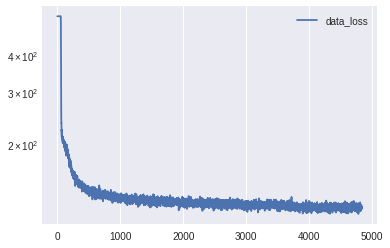

In [16]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

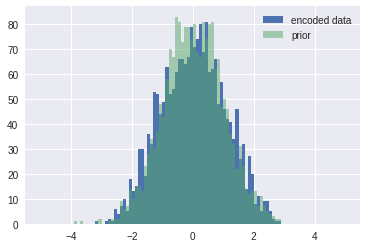

In [18]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

(?, 256, 784)


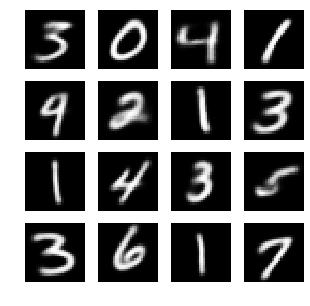

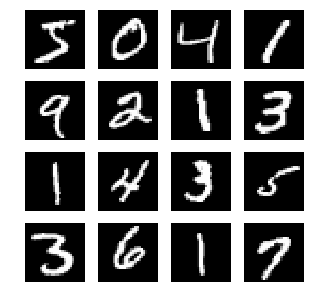

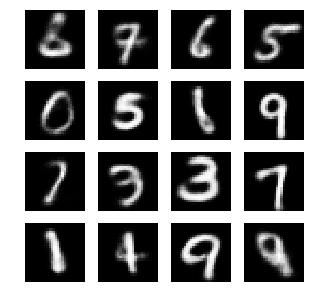

In [19]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 400})
print(x_sims.shape)
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [25]:
mask = np.ones(IMAGE_SHAPE)
#mask[0:,10:14]=0
#mask[13:16,0:28]=0

mask = mask.reshape((28*28))
mask = np.asarray([mask]*batch_size)
print(mask.shape)

(256, 784)


In [0]:
masked_data = x_valid[0:batch_size]*mask

In [0]:
zs  = sess.run(z_samples, feed_dict={x: x_valid[0:batch_size], sample_size:200 })

In [0]:
posterior2_loss=[]

In [39]:
lrate=1e-20
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data})
    print(mus[0:10])
  print(ll)

[[-5.1368129e-01 -8.4891379e-01 -6.6587865e-01 -5.1253337e-02
  -1.0692986e+00 -6.7565036e-01  6.9073409e-01  1.4312119e+00]
 [ 8.6473453e-01 -1.6273383e+00 -2.2310831e-01 -4.0247333e-01
   3.5847747e-01 -7.6714671e-01 -8.4310746e-01  8.0024534e-01]
 [ 5.5898499e-01  8.3488010e-02  1.3515972e+00  6.6433722e-01
   5.6127328e-01  2.2329416e+00 -1.1423794e+00  6.9335783e-01]
 [-1.6637231e+00  2.7834013e-01 -1.1293171e-01 -1.2102323e+00
   2.2044718e+00  7.6498270e-01 -3.5490859e-02  4.6855092e-02]
 [ 1.0848994e+00 -2.4231118e-01  5.1406878e-01  8.0800140e-01
   1.1148263e+00  3.5620740e-01 -3.7768688e-02  1.2825327e+00]
 [-1.4111872e+00 -4.1372482e-02  2.1709452e+00 -1.4641321e+00
   1.3903259e+00  1.3187634e+00 -5.0946945e-01  6.2129265e-01]
 [ 3.1007724e+00  1.5898737e+00 -6.5495986e-01 -6.1545986e-01
  -9.3569410e-01 -1.8305339e+00  4.1535076e-01 -1.7916553e+00]
 [-8.7267894e-01 -2.9214913e-01 -8.3007592e-01  4.4906262e-01
   1.6794173e-01  2.2729130e-01  4.3247595e-01  2.1458092e+00]


In [0]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res2 = sess.run(z2, feed_dict={x: x_test[0:batch_size]})
res = sess.run(z, feed_dict={x: x_test[0:batch_size]})

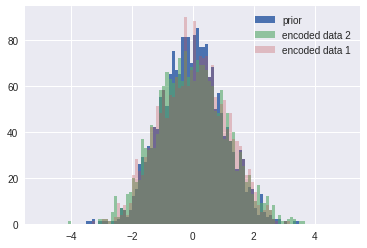

In [48]:
hist(randn(len(res.flatten())),100,range=[-5,5],label='prior');
hist(res2.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 2');
hist(res.flatten(),100,range=[-5,5],alpha=0.3,label='encoded data 1');
legend()

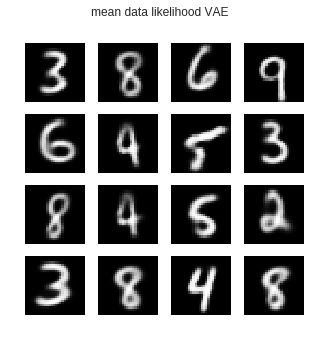

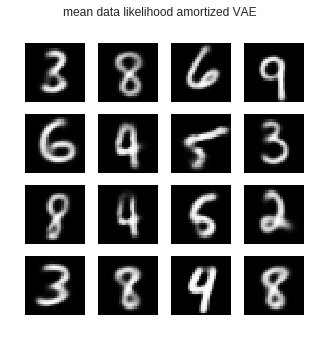

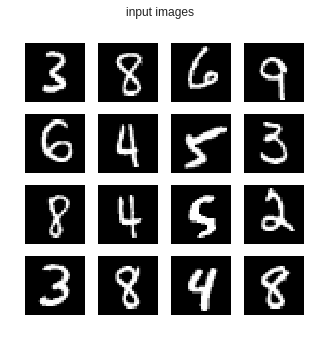

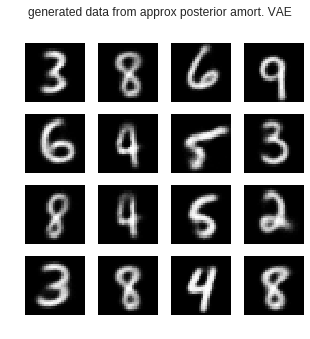

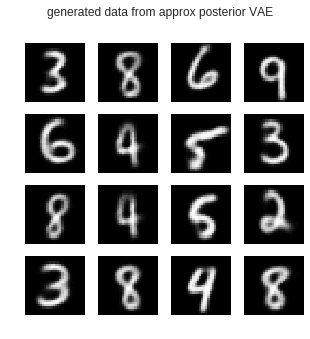

In [73]:
res2, inim, xrecons2 = sess.run([data_likelihood2.mean(), x, x2_samples], feed_dict={x: x_valid[0:batch_size], sample_size: 20})
res, xrecon          = sess.run([data_likelihood2.mean(),x_samples], feed_dict={x: x_valid[0:batch_size], sample_size: 20})


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('mean data likelihood amortized VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [82]:
lrate=1e-18
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data})
    print(mus[0:10])
  print(ll)

[[-0.58269966 -0.9072611  -0.5425587  -0.06640501 -0.9867915  -0.17477947
   0.57263124  1.3779813 ]
 [ 1.1713322  -1.4048331  -0.33500466 -0.433098    0.250533   -0.40808034
  -0.6291496   0.75690204]
 [ 0.8169209  -0.01532063  1.0606121   0.42086944  0.36074847  2.1546862
  -0.91625315  0.7206522 ]
 [-1.6233066   0.21154648 -0.09979045 -1.2761999   2.058929    1.3991688
   0.25853008  0.0904274 ]
 [ 1.7130573  -0.4268899   0.50787735  0.42912102  0.695564    0.83579874
  -0.17035091  1.2225072 ]
 [-1.2808868  -0.20057264  2.0168242  -1.4202632   1.2410756   1.6797779
  -0.37102604  0.63646114]
 [ 3.368372    1.0082556  -0.8331573  -0.6369798  -0.98431814 -1.7525411
   1.2303386  -1.6149868 ]
 [-0.9362969  -0.23314403 -0.8966937   0.4805873   0.23611163  0.50513464
   0.46965647  2.0340874 ]
 [ 0.26234576 -0.9759171  -0.24706343 -0.590702   -0.40918124  0.3331443
  -1.7290459   0.2827911 ]
 [-0.7033629  -0.64788413  1.8778522  -1.4060819   0.8238832   1.5641638
  -0.23707624  0.642823

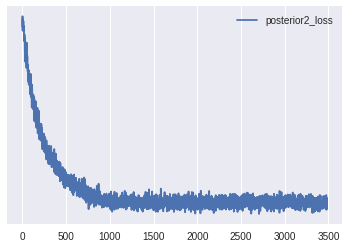

In [83]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [78]:
mask = np.ones(IMAGE_SHAPE)
#mask[0:,10:14]=0
mask[13:16,0:28]=0

mask = mask.reshape((28*28))
mask = np.asarray([mask]*batch_size)
print(mask.shape)

(256, 784)


In [0]:
masked_data = x_valid[0:batch_size]*mask

In [0]:
res3 = sess.run(z2, feed_dict={x: x_test[0:batch_size]})

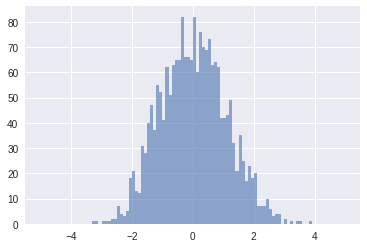

In [88]:
# hist(randn(len(res.flatten())),100,range=[-5,5],label='prior');
# hist(res2.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 2');
#hist(res.flatten(),100,range=[-5,5],alpha=0.3,label='encoded data 1');
#hist(res3.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 3');
# legend()

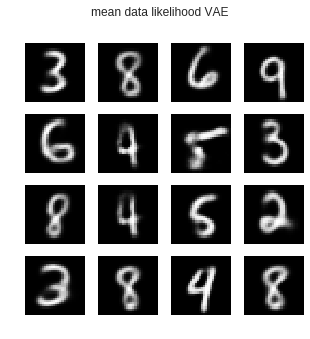

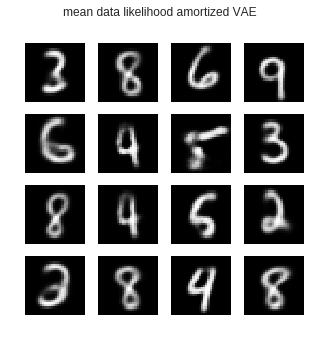

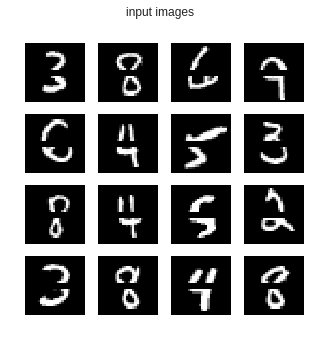

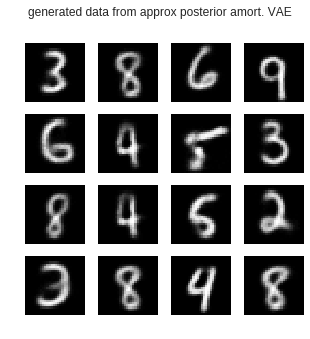

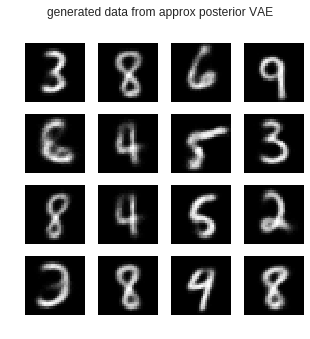

In [90]:
res2, inim, xrecons2 = sess.run([data_likelihood2.mean(), x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})
res, xrecon          = sess.run([data_likelihood2.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})

figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('mean data likelihood amortized VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')